# Market and Liquidity Risk - Risk Report 12/2023
### Tommaso de Leo - Cesare Cottonaro

# 1 Packages used for the analysis:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pathlib import Path
import seaborn as sns
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.plotting import (plot_perf_stats,
                              show_perf_stats,
                              plot_rolling_beta,
                              plot_rolling_returns,
                              plot_rolling_sharpe,
                              plot_drawdown_periods,
                              plot_drawdown_underwater)

from pyfolio.timeseries import perf_stats, extract_interesting_date_ranges
import yfinance as yf
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis, kurtosistest, norm, t
import scipy.stats as stats
from matplotlib import cm
import pyfolio as pf
import tqdm
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

# 2 Portfolio composition

In [ ]:
stocks = ['AMT', 'BXP', 'CCI', 'DLR', 'EQR', 'IRM', 'PSA']
portfolio_value = 10**6 # Initial portfolio value to be allocated
weights = [1/7 , 1/7, 1/7, 1/7, 1/7, 1/7, 1/7] # Initial weight allocation per asset

start_date = '2019-01-01'   # Start date for asset data download
end_date = '2024-01-01'     # End date for asset data download

In [ ]:
stock_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
stock_data = stock_data.dropna()
stock_data = stock_data.reindex(columns=stocks)
stock_prices = stock_data[stocks].values

[*********************100%%**********************]  7 of 7 completed


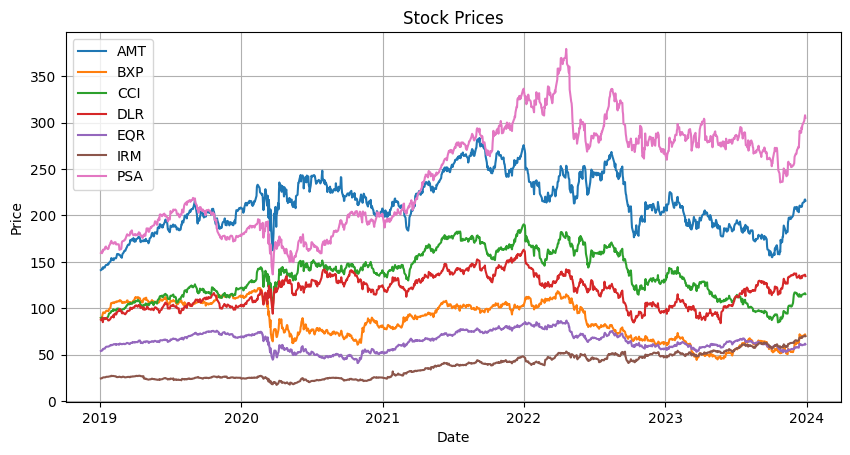

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4.8))

# Plot prices
for stock in stocks:
    ax.plot(stock_data.index, stock_data[stock], label=stock)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='best')
plt.title('Stock Prices')
plt.grid()
plt.show()

## 2.1 Returns analysis

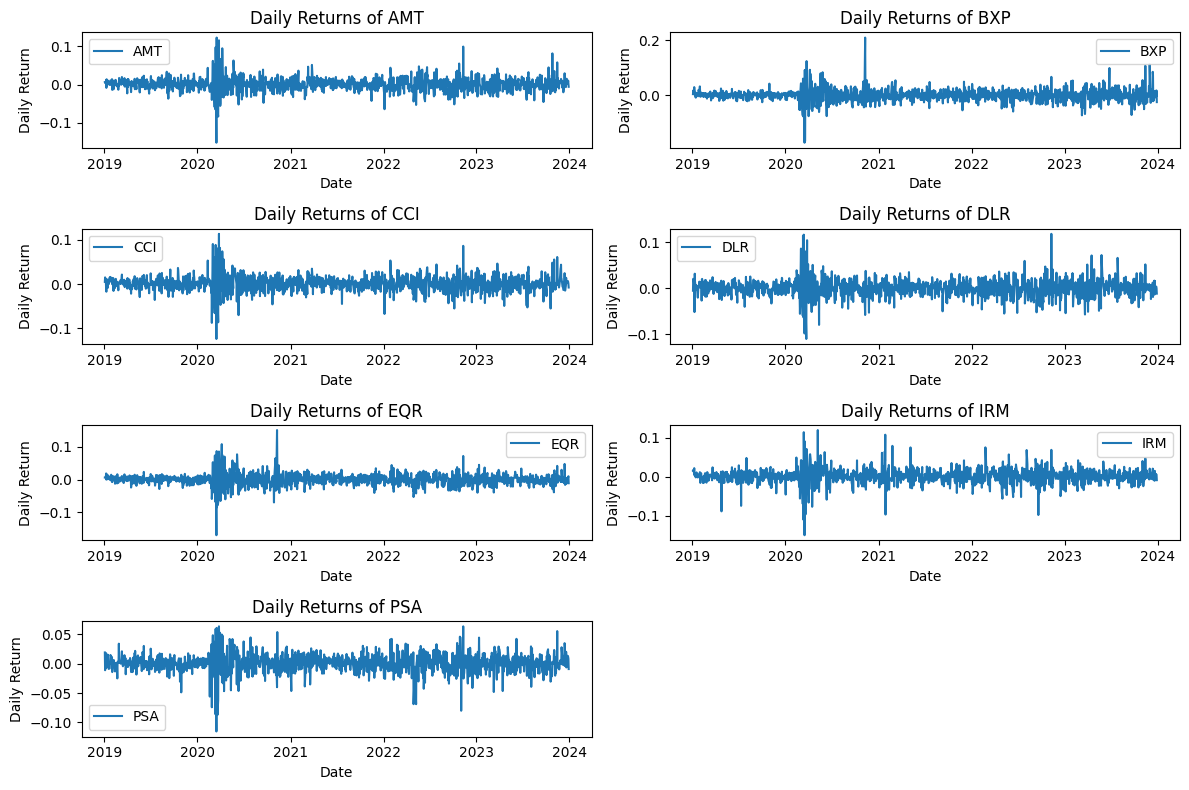

In [ ]:
# Calculate daily returns for each stock
returns = stock_data.pct_change()

# Drop the first row since it will contain NaN values
returns = returns.dropna()

# Plot the daily returns for each stock in subplots
num_plots = len(returns.columns)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axs = axs.flatten()  # Flatten the array of axes for easy indexing


for i, column in enumerate(returns.columns):
    ax = axs[i]
    ax.plot(returns.index, returns[column], label=column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Return')
    ax.set_title(f'Daily Returns of {column}')
    ax.legend()


for j in range(i + 1, num_cols * num_rows):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

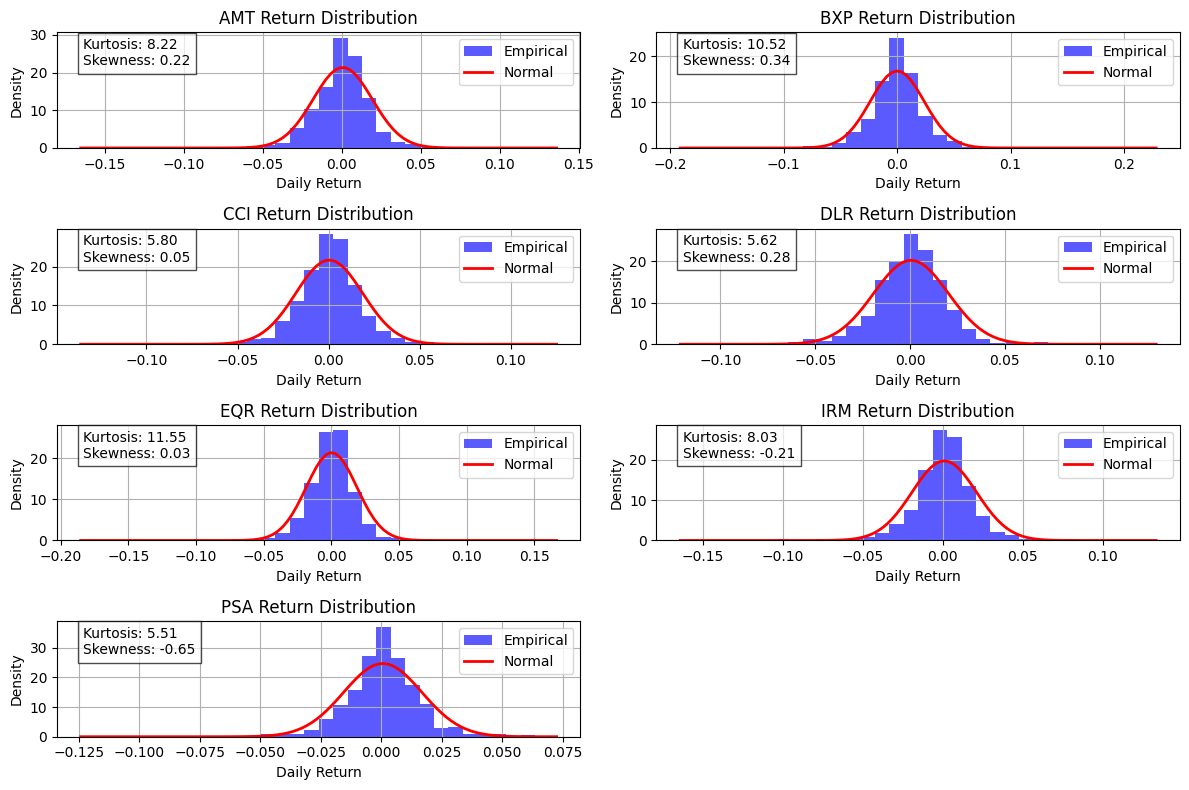

In [ ]:
# Get the number of stocks
num_stocks = len(stock_data.columns)

# Calculate the number of rows and columns needed for subplots
num_rows = (num_stocks + 1) // 2
num_cols = 2

# Plot the distribution of daily returns for each stock in subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axs = axs.flatten()  # Flatten the array of axes for easy indexing

for i, stock in enumerate(stock_data.columns):
    ax = axs[i]
    returns = stock_data[stock].pct_change().dropna()
    ax.hist(returns, bins=30, alpha=0.7, density=True, label='Empirical', color = '#1414ff')

    # Fit a normal distribution to the data
    mu, sigma = stats.norm.fit(returns)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, sigma)
    ax.plot(x, p, 'r', linewidth=2, label='Normal')

    # Calculate and display kurtosis and skewness
    kurtosis = stats.kurtosis(returns)
    skewness = stats.skew(returns)
    ax.text(0.05, 0.95, f'Kurtosis: {kurtosis:.2f}\nSkewness: {skewness:.2f}',
            verticalalignment='top', horizontalalignment='left', transform=ax.transAxes,
            fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    ax.set_xlabel('Daily Return')
    ax.set_ylabel('Density')
    ax.set_title(f'{stock} Return Distribution')
    ax.legend()
    ax.grid(True)

for j in range(i + 1, num_cols * num_rows):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize an empty dictionary to store scores for each stock
stock_scores = {}

for stock in stock_data.columns:
    returns = stock_data[stock].pct_change().dropna()

    # Perform the Anderson-Darling test
    ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson(returns, dist='norm')

    # Calculate the absolute difference between the test statistic and the critical values
    ad_diff = np.abs(ad_statistic - ad_critical_values)

    # Sum the absolute differences
    ad_score = ad_diff.sum()

    # Store the score for the current stock
    stock_scores[stock] = ad_score

# Sort stocks based on their scores in ascending order
sorted_stocks = sorted(stock_scores, key=stock_scores.get)

print("Stocks ranked by similarity to a normal distribution:")
for rank, stock in enumerate(sorted_stocks, start=1):
    print(f"{rank}. {stock} - Score: {stock_scores[stock]}")

Stocks ranked by similarity to a normal distribution:
1. DLR - Score: 50.62510324895703
2. CCI - Score: 62.67475904421308
3. PSA - Score: 63.243548020090024
4. AMT - Score: 64.02092946626571
5. BXP - Score: 79.37507026816097
6. EQR - Score: 92.94616097833347
7. IRM - Score: 101.61691815489013


# 3 Portfolio strategy

In [ ]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

# set initial shares on the first day
for s, w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df

,AMT_shares,BXP_shares,CCI_shares,DLR_shares,EQR_shares,IRM_shares,PSA_shares
2019-01-02,1022.0,1632.0,1626.0,1658.0,2683.0,6057.0,901.0


In [ ]:
# REBALANCING (Monthly based)

# set initial shares on the first day
shares_df.loc[stock_data.index[0], :] = [np.floor((portfolio_value * w) / stock_data[s][0]) for s,w in zip(stocks, weights)]

# initialize variables
balance_month = stock_data.index[0].month  # initialize with the month of the first day
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([shares_df.loc[stock_data.index[0], s + '_shares'] * stock_data.loc[stock_data.index[0], s] for s in stocks])

for day in stock_data.index:
    count += 1
    if day == stock_data.index[0]:
        shares_df.loc[day] = shares_df.loc[day] # First day

        # Store initial values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]


    elif day.month != balance_month:
        signal = True
        # calculate new shares based on the new portfolio value and weights
        new_shares = [np.floor((portfolio_value * w) / stock_data[s][day]) for s,w in zip(stocks, weights)]
        shares_df.loc[day, :] = new_shares
        balance_month = day.month
        count += 1
        # Store new values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]

    else:

        signal = False

        # Use previous values if it is not a rebalancing date
        shares_df.loc[day, :] = [prev_values[col] for col in shares_df.columns]


    # Calculate asset values and portfolio value for the current day
    asset_values = [shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)

    stock_data.loc[day, 'Signal'] = signal
    stock_data.loc[day, 'Portfolio_Value'] = portfolio_value

    # Add shares to stock data frame
    for s in stocks:
        stock_data.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
        stock_data.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s]

In [ ]:
# Calculate log returns for portfolio
stock_data['Portfolio_Value_rets'] = np.log(stock_data['Portfolio_Value'] / stock_data['Portfolio_Value'].shift(1))

# Calculate log returns for each stock and asset weight
for stock in stocks:
    stock_data[f'{stock}_rets'] = np.log(stock_data[stock] / stock_data[stock].shift(1))
    stock_data[stock + '_weight'] = stock_data[stock + '_value'] / stock_data['Portfolio_Value']

stock_data = stock_data.dropna()

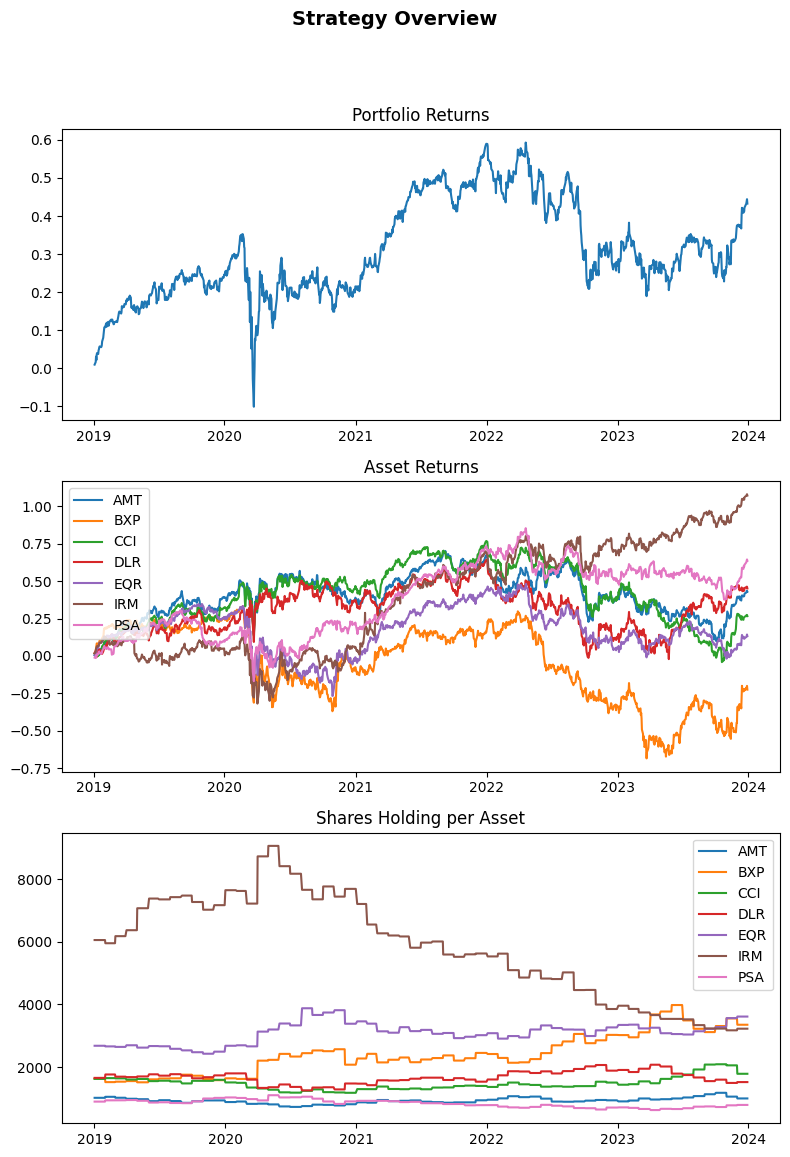

In [ ]:
# Create subplot layout
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot Portfolio Returns
axs[0].plot(stock_data.index, stock_data['Portfolio_Value_rets'].cumsum())
axs[0].set_title('Portfolio Returns')

# Plot Asset Returns
for s in stocks:
    axs[1].plot(stock_data.index, stock_data[f'{s}_rets'].cumsum(), label=f'{s}')

axs[1].set_title('Asset Returns')

# Plot Shares Holding per Asset
for s in stocks:
    axs[2].plot(shares_df.index, shares_df[f'{s}_shares'], label=f'{s}')

axs[2].set_title('Shares Holding per Asset')

# Add legend
axs[1].legend(loc='upper left')
axs[2].legend()

# Set overall title with additional space
fig.suptitle('Strategy Overview', y=0.99, fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add padding to the top

# Display the plot
plt.show()

# 4 Calculating VaR 95% and 99% on portfolio returns

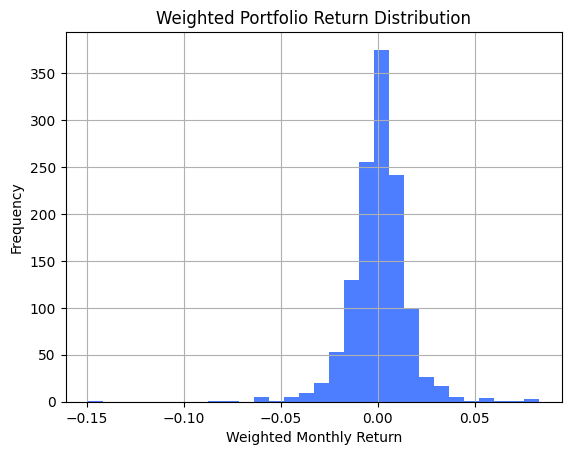

In [ ]:
# Plot the histogram for weighted portfolio return distribution
plt.figure()
plt.hist(stock_data['Portfolio_Value_rets'], bins=30, alpha=0.7, color='#0048ff')
plt.xlabel('Weighted Monthly Return')
plt.ylabel('Frequency')
plt.title('Weighted Portfolio Return Distribution')
plt.grid(True)
plt.show()

Distribution's mean: 0.0003 %
95% Empirical VaR: 2.04 %
99% Empirical VaR: 3.90 %


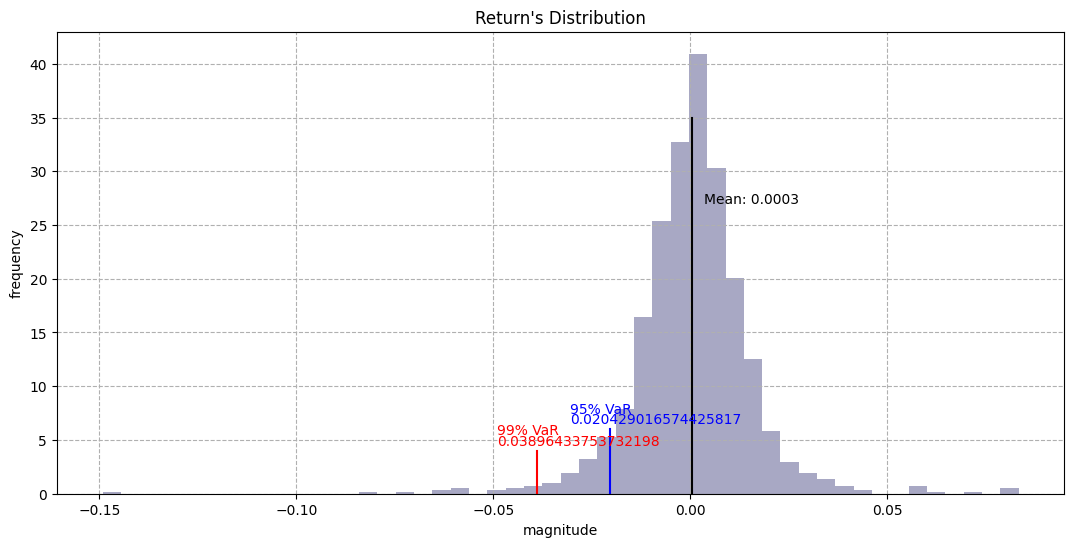

In [ ]:
alpha1 = 0.05
alpha2 = 0.01

sorted_ret = np.sort(stock_data['Portfolio_Value_rets'])

mu = stock_data['Portfolio_Value_rets'].mean()
print("Distribution's mean: %.4f %%" %
        mu
 )

var95 = abs(sorted_ret[int((1 - alpha1) * sorted_ret.shape[0])])
print("%.d%% Empirical VaR: %.2f %%" % ((
    1 - alpha1) * 100,
    var95 * 100)
 )

var99 = abs(sorted_ret[int((1 - alpha2) * sorted_ret.shape[0])])
print("%.d%% Empirical VaR: %.2f %%" % ((
    1 - alpha2) * 100,
    var99 * 100)
 )

grey = (.66, .66, .77)
plt.figure(figsize=(13, 6))
plt.title("Return's Distribution")
plt.ylabel("frequency")
plt.xlabel("magnitude")
plt.hist(stock_data['Portfolio_Value_rets'], bins=50, density=True, color=grey, edgecolor='none')
plt.text(mu + 0.003, 27, "Mean: %.4f" % mu, color='black')
plt.plot([mu, mu], [0, 35], c='black')
plt.plot([-var95, -var95], [0, 6], c='b')
plt.text(-var95 - 0.01, 7.5, "95% VaR", color='b')
plt.text(-var95 - 0.01, 6.5, str(var95), color='b')
plt.plot([-var99, -var99], [0, 4], c='r')
plt.text(-var99 - 0.01, 5.5, "99% VaR", color='r')
plt.text(-var99 - 0.01, 4.5, str(var99), color='r')
plt.grid(linestyle='--')

95% Normal VaR: 2.45 %
99% Normal VaR: 3.48 %


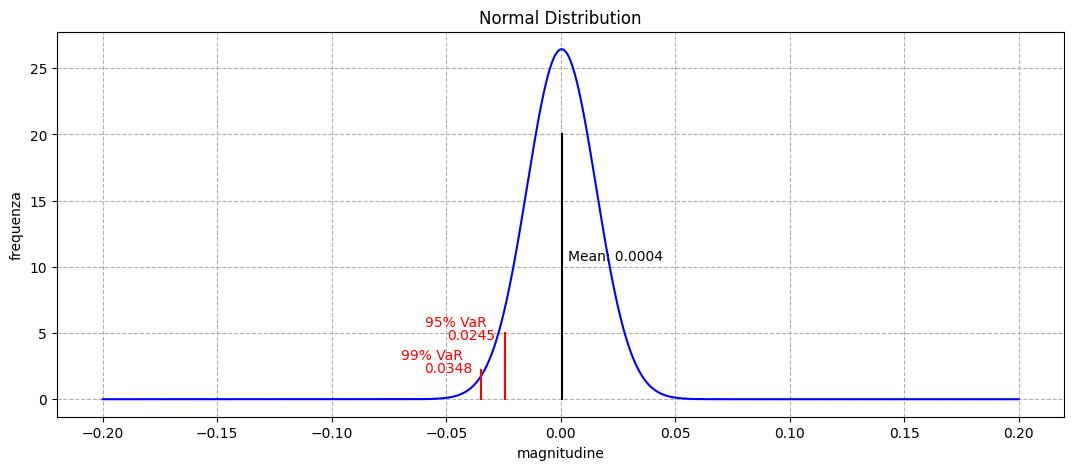

In [ ]:
mu_norm, sig_norm = norm.fit(stock_data['Portfolio_Value_rets'])
dx = 0.0001  # resolution
x = np.arange(-0.2, 0.2, dx)
pdf = norm.pdf(x, mu_norm, sig_norm)

var95 = norm.ppf(1 - alpha1) * sig_norm - mu_norm
var99 = norm.ppf(1 - alpha2) * sig_norm - mu_norm

print("%.d%% Normal VaR: %.2f %%" % ((
    1 - alpha1) * 100,
    var95 * 100)
     )
print("%.d%% Normal VaR: %.2f %%" % ((
    1 - alpha2) * 100,
    var99 * 100)
     )

plt.figure(figsize=(13, 5))
plt.plot(x, pdf, 'b')
plt.title("Normal Distribution")
plt.ylabel("frequenza")
plt.xlabel("magnitudine")
plt.text(mu_norm+0.003, 10.5, "Mean: %.4f" % mu_norm, color='black')
plt.plot([mu_norm, mu_norm], [0, 20], c='black')
plt.plot([-var95, -var95], [0, 5], c='r')
plt.text(-var95-0.035, 5.5, "95% VaR", color='r');
plt.text(-var95-0.025, 4.5, "%.4f" % var95, color='r');
plt.plot([-var99, -var99], [0, 2.2], c='r')
plt.text(-var99-0.035, 3, "99% VaR", color='r');
plt.text(-var99-0.025, 2, "%.4f" % var99, color='r');
plt.grid(linestyle='--')

## 4.1 Calculate 95% and 99% VaR for each month from 2022-01-01 (Historical Simulation)

In [ ]:
# Calculate monthly volatility
monthly_volatility = stock_data['Portfolio_Value_rets'].groupby(pd.Grouper(freq='M')).std() * np.sqrt(252)

# Calculate monthly VaR at 99% and 95% confidence levels
monthly_var_99 = stock_data['Portfolio_Value_rets'].groupby(pd.Grouper(freq='M')).apply(lambda x: np.percentile(x, 1))
monthly_var_95 = stock_data['Portfolio_Value_rets'].groupby(pd.Grouper(freq='M')).apply(lambda x: np.percentile(x, 5))

# Convert VaR quantities to positive percentages
monthly_var_99_percent = abs(monthly_var_99) * 100
monthly_var_95_percent = abs(monthly_var_95) * 100

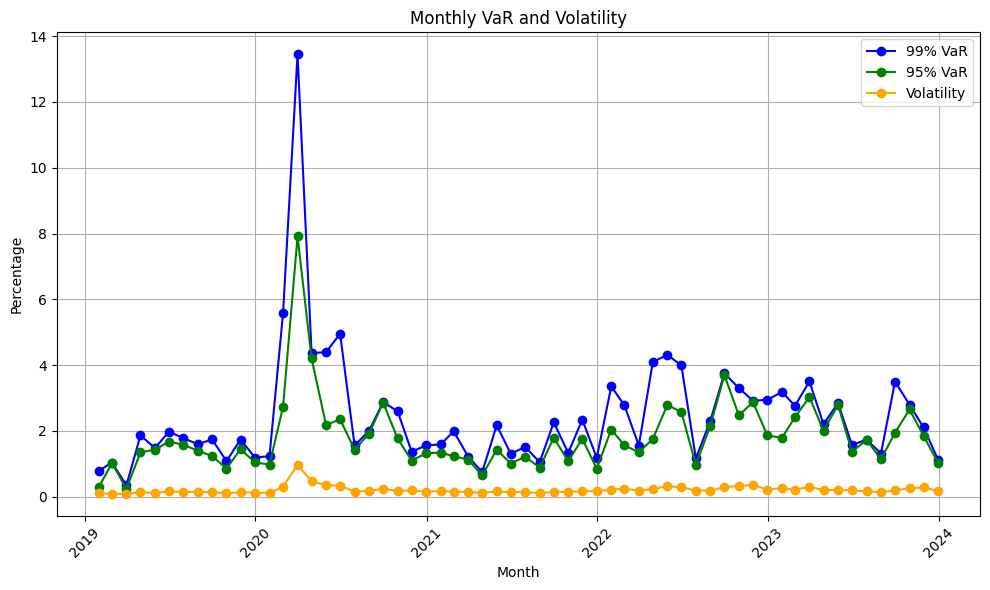

In [ ]:
# Plot all three parameters
plt.figure(figsize=(10, 6))

plt.plot(monthly_var_99_percent, label='99% VaR', marker='o', color='blue')
plt.plot(monthly_var_95_percent, label='95% VaR', marker='o', color='green')
plt.plot(monthly_volatility, label='Volatility', marker='o', color='orange')

plt.title('Monthly VaR and Volatility')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Zip the four series together for iteration
data = zip(monthly_var_99_percent, monthly_var_95_percent, monthly_volatility, monthly_var_99_percent.index)

# Print the data in four columns
print("99% VaR\t95% VaR\tVolatility\tDate")
for var_99, var_95, volatility, date in data:
    print(f"{var_99:.2f}%\t{var_95:.2f}%\t{volatility:.2f}\t{date.strftime('%Y-%m')}")

99% VaR	95% VaR	Volatility	Date
0.78%	0.29%	0.09	2019-01
1.03%	1.02%	0.09	2019-02
0.34%	0.24%	0.08	2019-03
1.86%	1.35%	0.13	2019-04
1.48%	1.43%	0.11	2019-05
1.97%	1.67%	0.16	2019-06
1.77%	1.58%	0.14	2019-07
1.59%	1.39%	0.14	2019-08
1.74%	1.24%	0.13	2019-09
1.08%	0.85%	0.10	2019-10
1.73%	1.44%	0.13	2019-11
1.18%	1.04%	0.12	2019-12
1.23%	0.97%	0.11	2020-01
5.58%	2.73%	0.29	2020-02
13.45%	7.91%	0.97	2020-03
4.36%	4.20%	0.46	2020-04
4.39%	2.18%	0.35	2020-05
4.95%	2.35%	0.33	2020-06
1.55%	1.43%	0.15	2020-07
2.00%	1.92%	0.17	2020-08
2.87%	2.86%	0.24	2020-09
2.59%	1.77%	0.17	2020-10
1.36%	1.10%	0.19	2020-11
1.56%	1.31%	0.15	2020-12
1.58%	1.34%	0.17	2021-01
1.99%	1.22%	0.15	2021-02
1.21%	1.12%	0.15	2021-03
0.75%	0.64%	0.11	2021-04
2.17%	1.43%	0.15	2021-05
1.30%	1.00%	0.13	2021-06
1.51%	1.21%	0.14	2021-07
1.04%	0.88%	0.10	2021-08
2.26%	1.79%	0.14	2021-09
1.33%	1.08%	0.14	2021-10
2.34%	1.76%	0.16	2021-11
1.18%	0.85%	0.16	2021-12
3.35%	2.04%	0.21	2022-01
2.78%	1.56%	0.24	2022-02
1.55%	1.35%	0.18	

## 4.2 Calculate 95% and 99% VaR for each month from 2022-01-01 (Parametric)

In [ ]:
monthly_volatility_p = stock_data['Portfolio_Value_rets'].groupby(pd.Grouper(freq='M')).std() * np.sqrt(252)

monthly_var_99_p = stock_data['Portfolio_Value_rets'].groupby(pd.Grouper(freq='M')).apply(lambda x: np.percentile(norm.fit(x), 1))
monthly_var_95_p = stock_data['Portfolio_Value_rets'].groupby(pd.Grouper(freq='M')).apply(lambda x: np.percentile(norm.fit(x), 5))

monthly_var_99_percent_p = abs(monthly_var_99_p) * 100
monthly_var_95_percent_p = abs(monthly_var_95_p) * 100

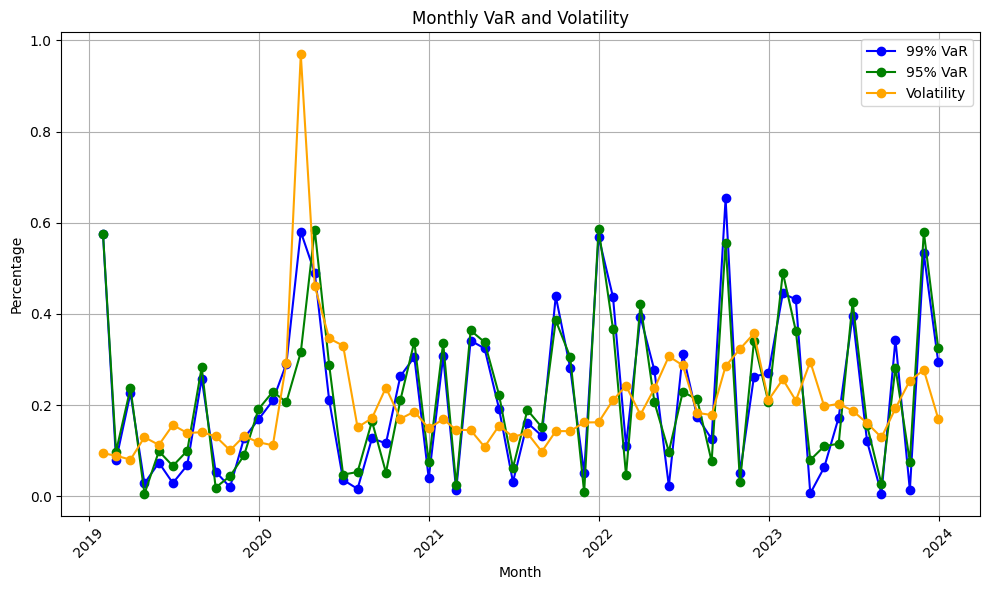

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(monthly_var_99_percent_p, label='99% VaR', marker='o', color='blue')
plt.plot(monthly_var_95_percent_p, label='95% VaR', marker='o', color='green')
plt.plot(monthly_volatility_p, label='Volatility', marker='o', color='orange')

plt.title('Monthly VaR and Volatility')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Zip the four series together for iteration
data_p = zip(monthly_var_99_percent_p, monthly_var_95_percent_p, monthly_volatility_p, monthly_var_99_percent_p.index)

# Print the data in four columns
print("99% VaR\t95% VaR\tVolatility\tDate")
for var_99, var_95, volatility, date in data_p:
    print(f"{var_99:.2f}%\t{var_95:.2f}%\t{volatility:.2f}\t{date.strftime('%Y-%m')}")

99% VaR	95% VaR	Volatility	Date
0.57%	0.57%	0.09	2019-01
0.08%	0.10%	0.09	2019-02
0.23%	0.24%	0.08	2019-03
0.03%	0.01%	0.13	2019-04
0.07%	0.10%	0.11	2019-05
0.03%	0.07%	0.16	2019-06
0.07%	0.10%	0.14	2019-07
0.26%	0.28%	0.14	2019-08
0.05%	0.02%	0.13	2019-09
0.02%	0.04%	0.10	2019-10
0.13%	0.09%	0.13	2019-11
0.17%	0.19%	0.12	2019-12
0.21%	0.23%	0.11	2020-01
0.29%	0.21%	0.29	2020-02
0.58%	0.32%	0.97	2020-03
0.49%	0.59%	0.46	2020-04
0.21%	0.29%	0.35	2020-05
0.04%	0.05%	0.33	2020-06
0.02%	0.05%	0.15	2020-07
0.13%	0.16%	0.17	2020-08
0.12%	0.05%	0.24	2020-09
0.26%	0.21%	0.17	2020-10
0.31%	0.34%	0.19	2020-11
0.04%	0.07%	0.15	2020-12
0.31%	0.34%	0.17	2021-01
0.01%	0.02%	0.15	2021-02
0.34%	0.36%	0.15	2021-03
0.32%	0.34%	0.11	2021-04
0.19%	0.22%	0.15	2021-05
0.03%	0.06%	0.13	2021-06
0.16%	0.19%	0.14	2021-07
0.13%	0.15%	0.10	2021-08
0.44%	0.39%	0.14	2021-09
0.28%	0.31%	0.14	2021-10
0.05%	0.01%	0.16	2021-11
0.57%	0.59%	0.16	2021-12
0.44%	0.37%	0.21	2022-01
0.11%	0.05%	0.24	2022-02
0.39%	0.42%	0.18	2

# 5 Estimation at the end of 2023

In [ ]:
import numpy as np

# Define the end date for estimating VaR
end_date = '2023-12-29'

# Filter the returns data to include only observations up to the end date
returns_filtered = stock_data['Portfolio_Value_rets'][:end_date]

# -----------------------------
# Monte Carlo Simulation Approach
# -----------------------------

# Calculate mean and standard deviation of returns for available data
mean_return_sim = returns_filtered.mean()
std_dev_return_sim = returns_filtered.std()

# Define parameters for the Monte Carlo simulation
num_simulations = 10000  # Number of simulations
initial_portfolio_value = 1000000  # Initial portfolio value

# Simulate future returns using a normal distribution with the calculated mean and standard deviation
simulated_returns = np.random.normal(mean_return_sim, std_dev_return_sim, (num_simulations,))

# Calculate future portfolio values for each simulation
future_portfolio_values_sim = initial_portfolio_value * np.exp(simulated_returns)

# Determine VaR at the specified quantiles (99% and 95%)
var_99_sim = np.percentile(future_portfolio_values_sim, 1)
var_95_sim = np.percentile(future_portfolio_values_sim, 5)

# Convert VaR values to percentage terms
var_99_pct_sim = (var_99_sim - initial_portfolio_value) / initial_portfolio_value
var_95_pct_sim = (var_95_sim - initial_portfolio_value) / initial_portfolio_value

# Calculate volatility for the Monte Carlo simulation
volatility_sim = std_dev_return_sim

# -----------------------------
# Historical Approach
# -----------------------------

# Sort the historical returns data
sorted_returns = np.sort(returns_filtered)

# Determine the loss corresponding to the specified quantiles (99% and 95%)
var_99_historical = np.percentile(sorted_returns, 1)
var_95_historical = np.percentile(sorted_returns, 5)

# Convert VaR values to percentage terms
var_99_pct_historical = var_99_historical
var_95_pct_historical = var_95_historical

# Calculate volatility for the historical approach
volatility_historical = np.std(sorted_returns)

# Print the results
print("Monte Carlo Simulation Approach:")
print(f"VaR 99%: {var_99_pct_sim:.2%}")
print(f"VaR 95%: {var_95_pct_sim:.2%}")
print(f"Volatility: {volatility_sim:.2%}")

print("\nHistorical Approach:")
print(f"VaR 99%: {var_99_pct_historical:.2%}")
print(f"VaR 95%: {var_95_pct_historical:.2%}")
print(f"Volatility: {volatility_historical:.2%}")


Monte Carlo Simulation Approach:
VaR 99%: -3.42%
VaR 95%: -2.42%
Volatility: 1.51%

Historical Approach:
VaR 99%: -4.26%
VaR 95%: -2.18%
Volatility: 1.51%


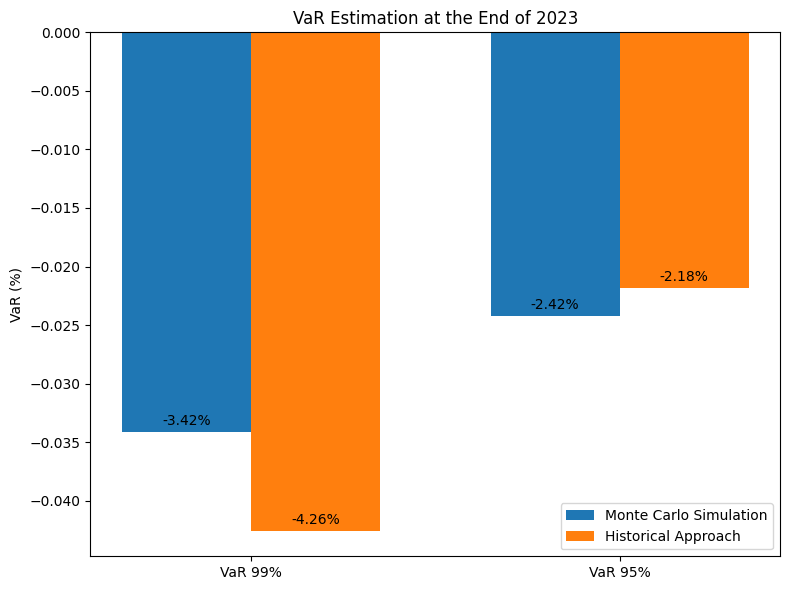

In [ ]:
# Define the labels for the bars
labels = ['VaR 99%', 'VaR 95%']

# Define the VaR estimates from Monte Carlo simulation and historical approach
var_sim = [var_99_pct_sim, var_95_pct_sim]
var_historical = [var_99_pct_historical, var_95_pct_historical]

# Define the x-axis positions
x = np.arange(len(labels))

# Define the width of the bars
width = 0.35

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, var_sim, width, label='Monte Carlo Simulation')
bars2 = ax.bar(x + width/2, var_historical, width, label='Historical Approach')

# Add labels, title, and legend
ax.set_ylabel('VaR (%)')
ax.set_title('VaR Estimation at the End of 2023')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add text annotations above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Show the plot
plt.tight_layout()
plt.show()

# 6 Stress testing

## 6.1 Stress test on portfolio returns

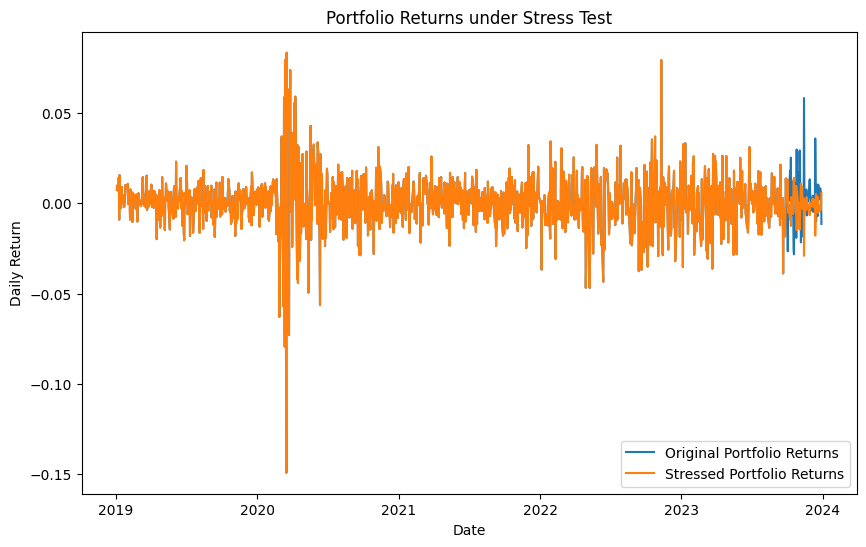

In [ ]:
# Define the stress period
stress_start_date = '2023-10-01'
stress_end_date = '2023-12-31'

# Define the stress factor
stress_factor = -0.5  # 50% decrease in portfolio returns during the stress period

# Apply stress test
stressed_portfolio_returns = stock_data['Portfolio_Value_rets'].copy()
stressed_portfolio_returns.loc[stress_start_date:stress_end_date] *= stress_factor

# Plot original and stressed portfolio returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Portfolio_Value_rets'], label='Original Portfolio Returns')
plt.plot(stressed_portfolio_returns, label='Stressed Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Portfolio Returns under Stress Test')
plt.legend()
plt.show()


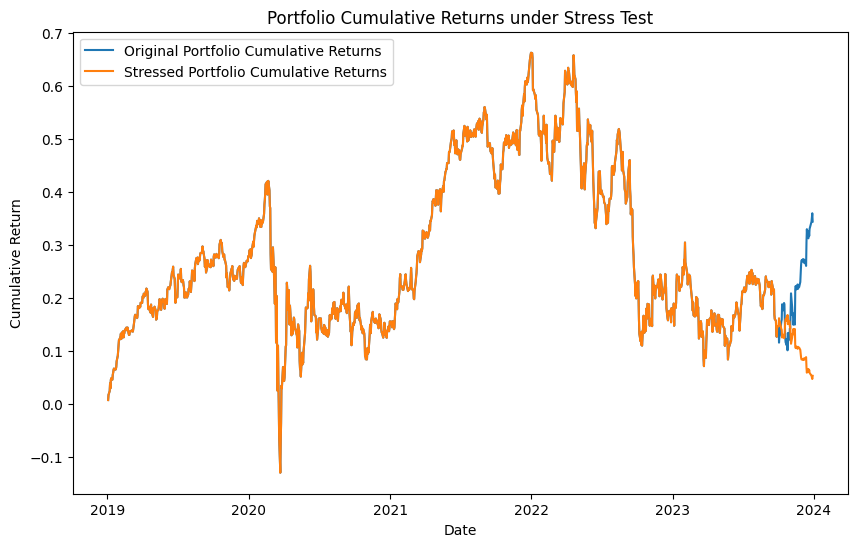

In [ ]:
# Calculate cumulative returns
cumulative_original_returns = (1 + stock_data['Portfolio_Value_rets']).cumprod() - 1
cumulative_stressed_returns = (1 + stressed_portfolio_returns).cumprod() - 1

# Plot original and stressed portfolio returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_original_returns, label='Original Portfolio Cumulative Returns')
plt.plot(cumulative_stressed_returns, label='Stressed Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio Cumulative Returns under Stress Test')
plt.legend()
plt.show()

In [ ]:
# Show the returns
stressed_portfolio_returns

Date
2019-01-03    0.007331
2019-01-04    0.009869
2019-01-07    0.006762
2019-01-08    0.014288
2019-01-09   -0.009063
                ...   
2023-12-22   -0.001036
2023-12-26   -0.004128
2023-12-27   -0.002679
2023-12-28   -0.003174
2023-12-29    0.005739
Name: Portfolio_Value_rets, Length: 1257, dtype: float64

In [ ]:
# Filter the stressed portfolio returns within the stress period
stressed_portfolio_returns_stress_period = stressed_portfolio_returns.loc[stress_start_date:stress_end_date]

# Calculate 99% VaR
var_99_s = stressed_portfolio_returns_stress_period.quantile(0.01)
var_99_r = stock_data['Portfolio_Value_rets'].loc[stress_start_date:stress_end_date].quantile(0.01)

# Calculate 95% VaR
var_95_s = stressed_portfolio_returns_stress_period.quantile(0.05)
var_95_r = stock_data['Portfolio_Value_rets'].loc[stress_start_date:stress_end_date].quantile(0.05)

print("99% VaR stressed portfolio:", abs(var_99_s)*100,"%")
print("95% VaR stressed portfolio:", abs(var_95_s)*100,"%")
print("99% VaR portfolio:", abs(var_99_r)*100,"%")
print("95% VaR portfolio:", abs(var_95_r)*100,"%")

99% VaR stressed portfolio: 2.217061863784262 %
95% VaR stressed portfolio: 1.4545727814726401 %
99% VaR portfolio: 2.722802005108738 %
95% VaR portfolio: 2.1409572328748756 %


## 6.2 Monte Carlo Simulation Approach VaR

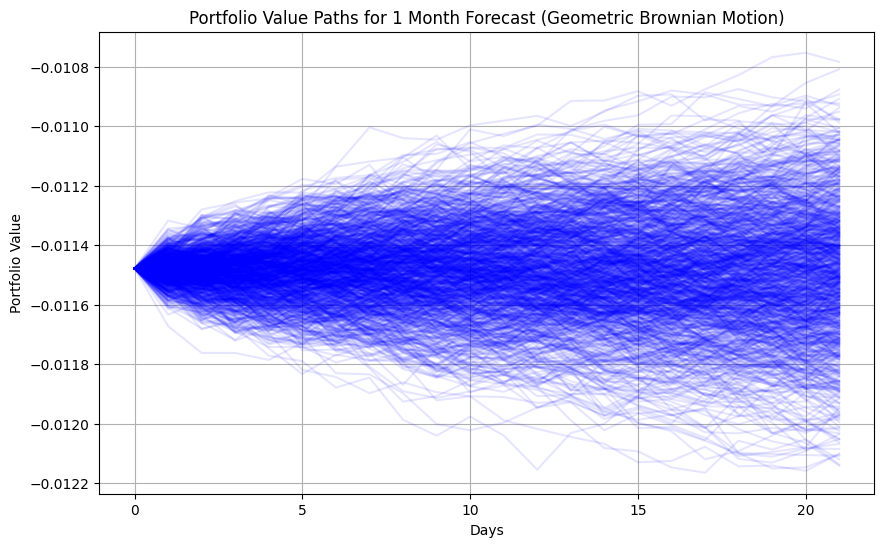

In [ ]:
# Extract returns from the dataframe
returns = stock_data['Portfolio_Value_rets'].values

# Calculate drift and volatility from historical returns
mu = returns.mean()
sigma = returns.std()

# Define parameters
S0 = stock_data['Portfolio_Value_rets'].iloc[-1]  # Initial portfolio value
T = 21  # Number of trading days (1 month, assuming 21 trading days)

# Number of paths to simulate
num_paths = 1000

# Generate random numbers for each path and each time step
np.random.seed(42)  # for reproducibility
random_values = np.random.normal((mu - 0.5 * sigma**2) * (T / 252), sigma * np.sqrt(T / 252), size=(T, num_paths))

# Initialize array to store simulated portfolio values
portfolio_values = np.zeros((T + 1, num_paths))
portfolio_values[0] = S0

# Simulate portfolio values using Geometric Brownian Motion
for t in range(1, T + 1):
    portfolio_values[t] = portfolio_values[t - 1] * np.exp(random_values[t - 1])

# Plot all paths
plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(portfolio_values[:, i], color='blue', alpha=0.1)
plt.title('Portfolio Value Paths for 1 Month Forecast (Geometric Brownian Motion)')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()


In [ ]:
sim_VaR_99 = np.percentile(portfolio_values, 1)
sim_VaR_95 = np.percentile(portfolio_values, 5)

print('Simulated VAR 99% is: ', abs(sim_VaR_99)*100,'%')
print('Simulated VAR 95% is: ', abs(sim_VaR_95)*100,'%')

Simulated VAR 99% is:  1.190915743018457 %
Simulated VAR 95% is:  1.1757513854809107 %


In [ ]:
print(1000000*sim_VaR_99,'€')
print(1000000*sim_VaR_95,'€')

-11909.157430184569 €
-11757.513854809107 €


## 6.3 Monte Carlo Simulation Approach stressed VaR

In [ ]:
# Calculate mean and standard deviation of returns for available data
mean_return_sim = returns_filtered.mean()
std_dev_return_sim = returns_filtered.std()

# Define parameters for the Monte Carlo simulation
num_simulations = 10000  # Number of simulations
initial_portfolio_value = 1000000  # Initial portfolio value

e = 0.01
# Simulate future returns using a normal distribution with the calculated mean and standard deviation
simulated_returns_stress = np.random.normal(mean_return_sim, std_dev_return_sim+e, (num_simulations,))

# Calculate future portfolio values for each simulation
future_portfolio_values_sim_stress = initial_portfolio_value * np.exp(simulated_returns_stress)

# Determine VaR at the specified quantiles (99% and 95%)
var_99_sim_stress = np.percentile(future_portfolio_values_sim_stress, 1)
var_95_sim_stress = np.percentile(future_portfolio_values_sim_stress, 5)

# Convert VaR values to percentage terms
var_99_pct_sim_stress = (var_99_sim_stress - initial_portfolio_value) / initial_portfolio_value
var_95_pct_sim_stress = (var_95_sim_stress - initial_portfolio_value) / initial_portfolio_value

# Calculate volatility for the Monte Carlo simulation
volatility_sim_stress = std_dev_return_sim

In [ ]:
# Print the results

print("Monte Carlo Simulation Approach stressed:")
print(f"VaR 99%: {abs(var_99_pct_sim_stress):.2%}")
print(f"VaR 95%: {abs(var_95_pct_sim_stress):.2%}")

Monte Carlo Simulation Approach stressed:
VaR 99%: 5.57%
VaR 95%: 3.93%


## 6.4 Structured Stress Test

In [ ]:
# Benchmark data download and returns
benchmark = '^IXIC' # NASDAQ as benchmark index
start_date_benchmark = stock_data.index[0]
benchmark_data = yf.download(benchmark, start=start_date, end=end_date)
benchmark_data = benchmark_data.dropna()
benchmark_data['benchmark_rets'] = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1))
benchmark_data['benchmark_rets'] = benchmark_data['benchmark_rets'].dropna()

stock_data.index = stock_data.index.tz_localize('UTC')
benchmark_data.index = benchmark_data.index.tz_localize('UTC')

factor_returns = benchmark_data['benchmark_rets'].reindex(stock_data['Portfolio_Value_rets'].index)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Combine the datasets
combined_data = pd.concat([factor_returns, stock_data['Portfolio_Value_rets']], axis=1).dropna()

# Define the independent variable (factor returns)
X = sm.add_constant(combined_data['benchmark_rets'])

# Define the dependent variable (portfolio returns)
y = combined_data['Portfolio_Value_rets']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())


                             OLS Regression Results                             
Dep. Variable:     Portfolio_Value_rets   R-squared:                       0.383
Model:                              OLS   Adj. R-squared:                  0.383
Method:                   Least Squares   F-statistic:                     778.5
Date:                  Mon, 04 Mar 2024   Prob (F-statistic):          1.16e-133
Time:                          18:11:19   Log-Likelihood:                 3788.2
No. Observations:                  1256   AIC:                            -7572.
Df Residuals:                      1254   BIC:                            -7562.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.261e-0

In [ ]:
# Sensitivity coefficient obtained from regression
sensitivity_coefficient = 0.5872

# Factor returns stress test scenario (decrease by 50%)
factor_returns_stress_test = factor_returns * 0.50

# Calculate the expected change in portfolio returns based on the sensitivity coefficient
expected_portfolio_return_change = sensitivity_coefficient * (factor_returns_stress_test - factor_returns)

# Combine the original and stressed factor returns
combined_factor_returns = pd.concat([factor_returns, factor_returns_stress_test], axis=1, keys=['Original', 'Stress Test'])

# Combine the original and expected change in portfolio returns
expected_portfolio_returns = pd.concat([stock_data['Portfolio_Value_rets'], expected_portfolio_return_change], axis=1, keys=['Original', 'Expected Change'])

# Print the results
print("Combined Factor Returns:")
print(combined_factor_returns.head())

print("\nExpected Change in Portfolio Returns:")
print(expected_portfolio_returns.head())


Combined Factor Returns:
                           Original  Stress Test
Date                                            
2019-01-03 00:00:00+00:00 -0.030840    -0.015420
2019-01-04 00:00:00+00:00  0.041720     0.020860
2019-01-07 00:00:00+00:00  0.012477     0.006239
2019-01-08 00:00:00+00:00  0.010718     0.005359
2019-01-09 00:00:00+00:00  0.008673     0.004337

Expected Change in Portfolio Returns:
                           Original  Expected Change
Date                                                
2019-01-03 00:00:00+00:00  0.007331         0.018310
2019-01-04 00:00:00+00:00  0.009869        -0.024769
2019-01-07 00:00:00+00:00  0.006762        -0.007408
2019-01-08 00:00:00+00:00  0.014288        -0.006363
2019-01-09 00:00:00+00:00 -0.009063        -0.005149


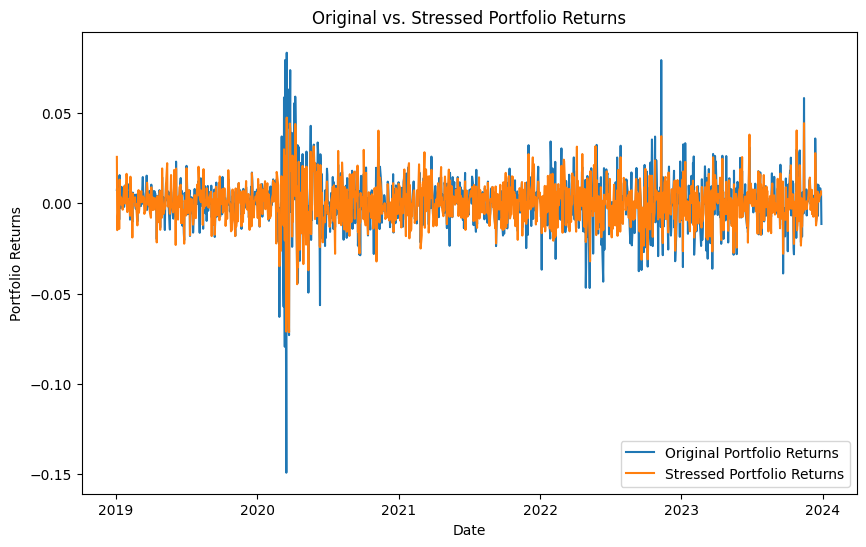

In [ ]:
# Calculate stressed portfolio returns
stressed_portfolio_returns = stock_data['Portfolio_Value_rets'] + expected_portfolio_return_change

# Plot original and stressed portfolio returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, stock_data['Portfolio_Value_rets'], label='Original Portfolio Returns')
plt.plot(stock_data.index, stressed_portfolio_returns, label='Stressed Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Portfolio Returns')
plt.title('Original vs. Stressed Portfolio Returns')
plt.legend()
plt.show()

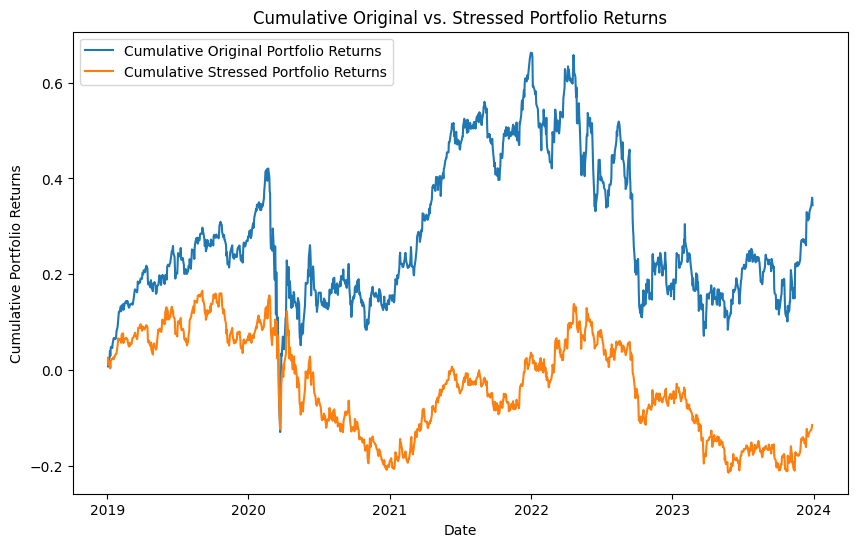

In [ ]:
# Calculate cumulative portfolio returns
cumulative_original_returns = (1 + stock_data['Portfolio_Value_rets']).cumprod() - 1
cumulative_stressed_returns = (1 + stressed_portfolio_returns).cumprod() - 1

# Plot cumulative original and stressed portfolio returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, cumulative_original_returns, label='Cumulative Original Portfolio Returns')
plt.plot(stock_data.index, cumulative_stressed_returns, label='Cumulative Stressed Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Portfolio Returns')
plt.title('Cumulative Original vs. Stressed Portfolio Returns')
plt.legend()
plt.show()


In [ ]:
stressed_portfolio_returns.name = 'stressed_portfolio_returns'

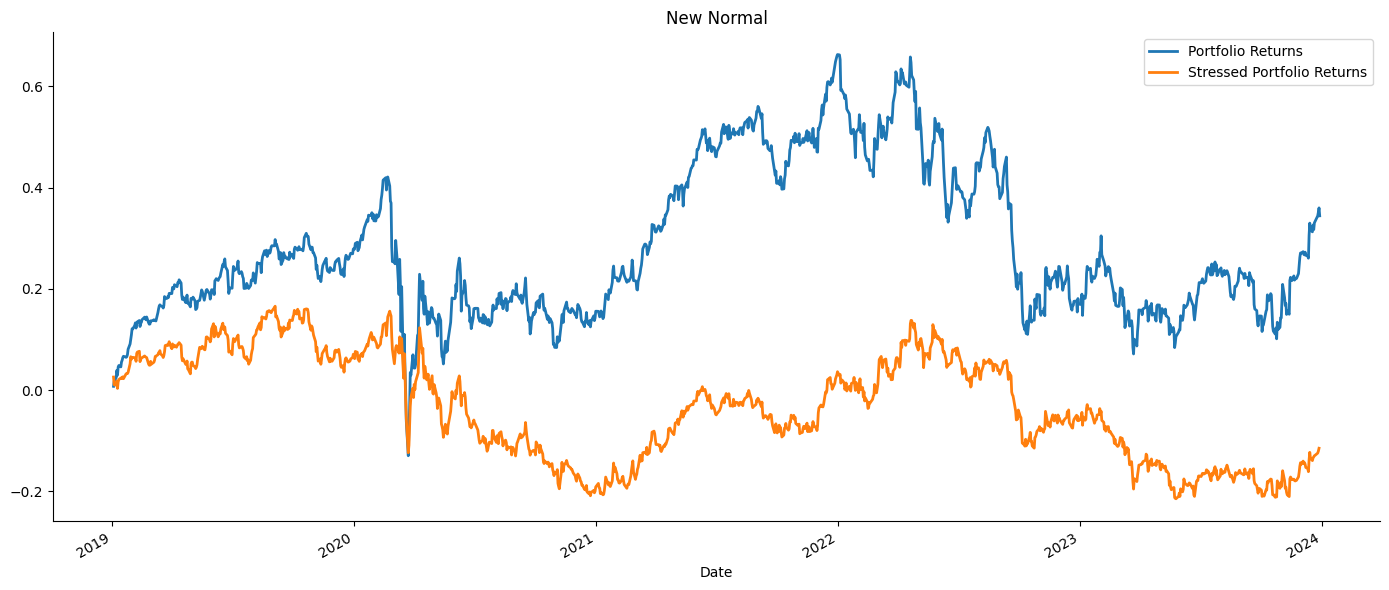

In [ ]:
def plot_events(event_data, stressed_portfolio_returns):
    fig, axes = plt.subplots(nrows=len(event_data), figsize=(14, 6 * len(event_data)))
    for i, (event, returns) in enumerate(event_data.items()):
        ax = axes[i] if len(event_data) > 1 else axes
        # Plot portfolio returns and factor (benchmark) returns with custom labels
        portfolio_returns = stock_data['Portfolio_Value_rets'][returns.index].to_frame('portfolio')
        stressed_portfolio_returns.columns = ['Stressed Returns']  # Rename the column
        combined_returns = portfolio_returns.join(stressed_portfolio_returns).add(1).cumprod().sub(1)
        combined_returns.plot(ax=ax, lw=2)
        ax.set_title(event)
        ax.legend(labels=['Portfolio Returns', 'Stressed Portfolio Returns'])  # Rename the legend labels
        sns.despine()
    plt.tight_layout()  # Call tight_layout on the Figure, not the Axes

# Extract interesting date ranges
interesting_times = extract_interesting_date_ranges(returns=stock_data['Portfolio_Value_rets'])

# Plot events
plot_events(interesting_times, stressed_portfolio_returns)

## 6.5 VaR 99% and 95% on stressed portfolio returns during stress events

In [ ]:
# Define the event ranges using the provided function
event_data = extract_interesting_date_ranges(stressed_portfolio_returns)

# Initialize lists to store VaR results
var_99 = []
var_95 = []

# Loop through each event and its corresponding returns
for event, returns in event_data.items():
    # Calculate VaR at 99% and 95% confidence levels for the current event
    var_99.append(np.percentile(returns, 1))
    var_95.append(np.percentile(returns, 5))

# Print or use the VaR results as needed
for i, event in enumerate(event_data.keys()):
    print(f"VaR (99%) for {event}: {abs(var_99[i])*100}%")
    print(f"VaR (95%) for {event}: {abs(var_95[i])*100}%")

VaR (99%) for New Normal: nan%
VaR (95%) for New Normal: nan%
